In [1]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [3]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
# Define parameters
filepaths = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/neurons/"
outputpath = "./test/"

area = "lip"
subject = "Riesling"
avgwin = 100
min_sp_sec = 5
n_test = 1
min_trials = 10
nonmatch = True  # if True: includes nonmatch trials

# sample timing
time_before_sample = 500
start_sample = -200
end_sample = 450 + 400

# test timing
time_before_test = 500
start_test = -400
end_test = n_test * 450 + 200
# -------------------------------------------- End parameters ------------------------------------------

# Compute idxs
idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration
trial_dur = end_sample - start_sample + end_test - start_test


In [6]:
# ------------------------------------------ Start preprocessing ----------------------------------------
neu_path = filepaths + "*neu.h5"
path_list = glob.glob(neu_path)


In [7]:
data = Parallel(n_jobs=-1)(
    delayed(get_neuron_sample_test_fr)(
        path=path,
        time_before_sample=time_before_sample,
        time_before_test=time_before_test,
        idx_start_sample=idx_start_sample,
        idx_end_sample=idx_end_sample,
        idx_start_test=idx_start_test,
        idx_end_test=idx_end_test,
        n_test=n_test,
        min_trials=min_trials,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
    )
    for path in tqdm(path_list)
)

100%|██████████| 530/530 [11:48<00:00,  1.34s/it]


In [8]:
seed=1997

In [43]:
s0,s11,s15,s51,s55 = [],[],[],[],[]
g1mean,g2mean=[],[]
gg1=[]
gg2=[]
rng = np.random.default_rng(seed)
s0mean, s11mean, s15mean, s51mean, s55mean,nnmean = [],[],[],[],[],[]
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        s0mean.append(np.mean(fr['0'],axis=0))
        s11mean.append(np.mean( fr['11'],axis=0))
        s15mean.append(np.mean( fr['15'],axis=0))
        s51mean.append(np.mean( fr['51'],axis=0))
        s55mean.append(np.mean( fr['55'],axis=0))
        nn=np.concatenate((fr['11'],fr['15'],fr['51'],fr['55']),axis=0)
        nnmean.append(np.mean(nn,axis=0))

        all_s = np.concatenate((fr['0'],fr['11'],fr['15'],fr['51'],fr['55']),axis=0)

        nn_idx_tr = rng.choice(len(all_s), size=len(fr['0'])*2, replace=False)


        #allsampl = nn=np.concatenate((fr['0'],nn[nn_idx_tr]),axis=0)

        #n_idx_tr = rng.choice(len(allsampl), size=20, replace=False)

        g1mean.append(np.mean(all_s[nn_idx_tr[:len(fr['0'])]],axis=0))
        g2mean.append(np.mean(all_s[nn_idx_tr[len(fr['0']):]],axis=0))


neurons_fr=[{'0mean':s0mean,'11mean':s11mean,'15mean':s15mean,'51mean':s51mean,'55mean':s55mean,'nnmean':nnmean,'g1mean':g1mean,'g2mean':g2mean}]

In [44]:
to_python_hdf5(dat=neurons_fr, save_path='trials_wintr_pca88.h5')

In [45]:
aa=from_python_hdf5('trials_wintr_pca88.h5')[0]

In [46]:
path_list=['trials_wintr_pca88.h5']

In [47]:
n_comp=100

In [48]:
pc_areas = {}
for path,area in zip(path_list,['lip']):#'lip',
    fr=from_python_hdf5(path)[0]
    fr_concat = np.concatenate((fr['0mean'],fr['11mean'],fr['15mean'],fr['51mean'],fr['55mean']),axis=1)
    fr_group_concat = np.concatenate((fr['g1mean'],fr['g2mean']),axis=1)

    print('%s %d'%(area,fr_concat.shape[0]))
    pc_areas[area] = {'n_neurons':fr_concat.shape[0],'allsamples_fr':fr_concat,'n_fr':fr['0mean'],'nn_fr':fr['nnmean'],'fr_group_concat':fr_group_concat}

lip 202


In [49]:
from scipy.spatial.distance import pdist
from ephysvibe.stats import smetrics

In [50]:
fr_group_concat.shape

(202, 4200)

In [57]:
res={'lip':{},'v4':{},'pfc':{}}
rng = np.random.default_rng(seed)
for area in ['lip']:
    all_distn=[]
    all_distnn=[]
    all_dist_n_nn=[]
    n_comp=100
    allidx_neu=[]
    allreshape_pc=[]
    alldist_fake_n_nn=[]
    tot_nneu=pc_areas[area]['n_neurons']
    for _ in range(1000):
        idx_neu = rng.choice(tot_nneu, size=n_comp, replace=False)
        allidx_neu.append(idx_neu)
        allsamp_fr=pc_areas[area]['allsamples_fr'][idx_neu]
        fr_group_concat=pc_areas[area]['fr_group_concat'][idx_neu]
    


        n_fr = pc_areas[area]['n_fr'][idx_neu]
        nn_fr = pc_areas[area]['nn_fr'][idx_neu]
        # neurons_fr=np.concatenate((n_fr,nn_fr),axis=1)

        reshape_pc = allsamp_fr.reshape(n_comp,5,-1)
        reshape_pc=np.concatenate((reshape_pc[:,0],np.mean(reshape_pc[:,1:],axis=1)),axis=1).reshape(n_comp,2,-1)
        
        fr_groups=fr_group_concat.reshape(n_comp,2,-1)
        distn=[]
        distnn=[]
        dist_n_nn=[]
        dist_fake_n_nn=[]
        for i in range(reshape_pc.shape[-1]):
            #dist.append(signed_euclidean_distance(nnpc[:,i].T, npc[:,i].T))
            reference = fr_groups[:,0,i]#np.zeros(n_comp) # allsamp_pc[:,i] # 
            distn.append(pdist(np.array((reshape_pc[:,0,i],reference))))
            distnn.append(pdist(np.array((reshape_pc[:,1,i],reference))))
            dist_n_nn.append(pdist(np.array((reshape_pc[:,0,i],reshape_pc[:,1,i]))))
            dist_fake_n_nn.append(pdist(np.array((fr_groups[:,0,i],fr_groups[:,1,i]))))

        all_distn.append(np.array(distn).reshape(-1))
        all_distnn.append(np.array(distnn).reshape(-1))
        all_dist_n_nn.append(np.array(dist_n_nn).reshape(-1))
        alldist_fake_n_nn.append(np.array(dist_fake_n_nn).reshape(-1))
    all_distn=np.array(all_distn)
    all_distnn=np.array(all_distnn)
    all_dist_n_nn=np.array(all_dist_n_nn)
    alldist_fake_n_nn=np.array(alldist_fake_n_nn)
    # group1=all_distnn
    # group2=all_distn
    group1=all_dist_n_nn
    group2=alldist_fake_n_nn
    roc_score, p = smetrics.compute_roc_auc(group1, group2)
    latency,_=smetrics.find_latency(
        p_value=p, win=75, step= 1, p_treshold= 0.05
    )
    res[area]['roc_score']=roc_score
    res[area]['latency']=latency
    res[area]['p']=p
    res[area]['all_distnn']=all_distnn
    res[area]['all_distn']=all_distn
    res[area]['allidx_neu']=allidx_neu
    res[area]['all_dist_n_nn']=all_dist_n_nn
    res[area]['alldist_fake_n_nn']=alldist_fake_n_nn
    print(area)
    print(latency-200)

In [ ]:
import matplotlib.pyplot as plt

lip
-200


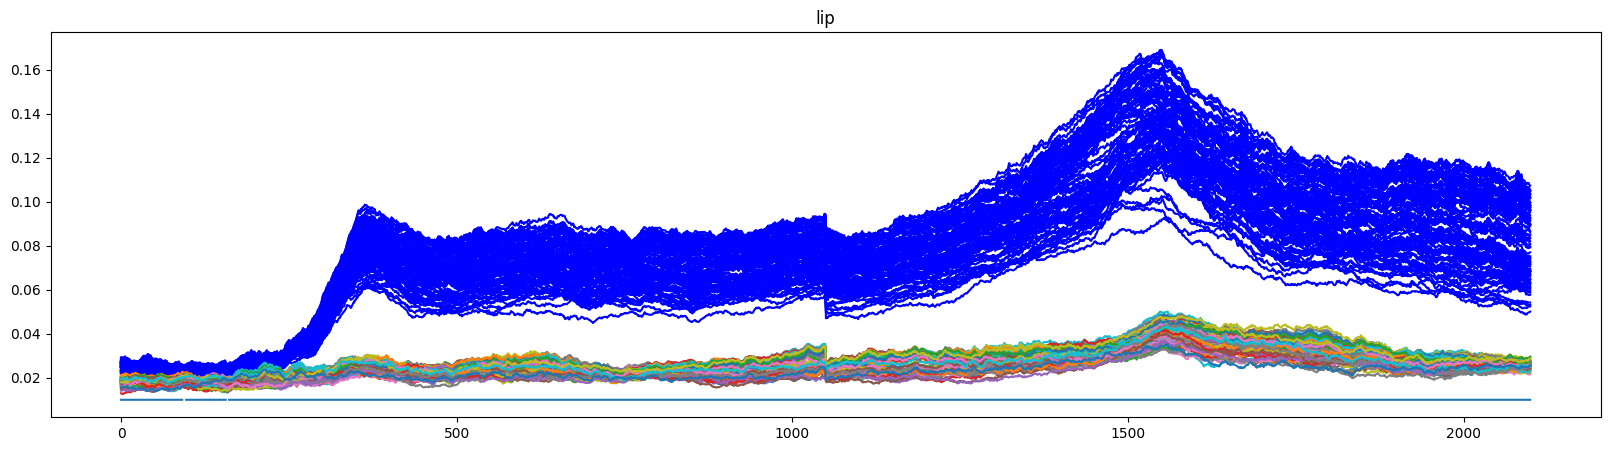

In [ ]:
_=plt.figure(figsize=(20,5))
for area in ['lip']:
    d=res[area]['all_distn']
    d_fix = d[:,:200]
    x_bar = np.mean(d_fix) 
    s = np.std(d_fix) 
    n = n_comp # number of obs
    z = 1.96 # for a 95% CI

    lower = x_bar - (z * (s/np.sqrt(n)))
    upper = x_bar + (z * (s/np.sqrt(n)))
    med = np.median(d_fix)
    sig=np.where(np.sum(d>upper,axis=0)/10 > 0.95,1,np.nan)

    _=plt.plot(d.T,'b')
    _=plt.plot(sig/100)
    # _=plt.hlines(upper,0,2100)
    # _=plt.vlines(200,0,0.2)
    # _=plt.vlines(200+100,0,0.2)
    p=res[area]['all_distnn']
    _=plt.plot(p.T)
    _=plt.title(area)
    print(area)
    print(np.where(sig==1)[0][0]-200)

lip
-200


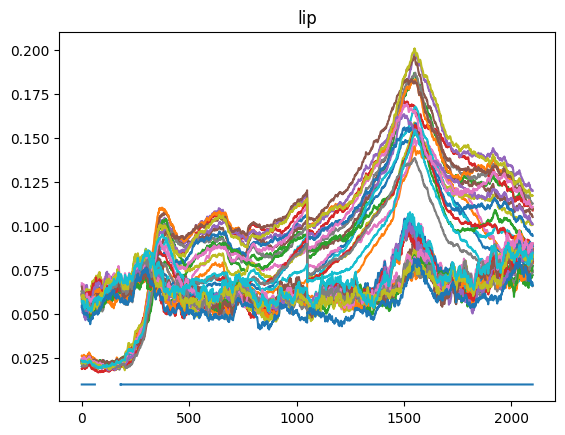

In [38]:
for area in ['lip']:
    d=res[area]['all_dist_n_nn']
    d_fix = d[:,:200]
    x_bar = np.mean(d_fix) 
    s = np.std(d_fix) 
    n = n_comp # number of obs
    z = 1.96 # for a 95% CI

    lower = x_bar - (z * (s/np.sqrt(n)))
    upper = x_bar + (z * (s/np.sqrt(n)))
    med = np.median(d_fix)
    sig=np.where(np.sum(d>upper,axis=0)/10 > 0.95,1,np.nan)
    _=plt.figure()
    _=plt.plot(d.T)
    _=plt.plot(sig/100)
    # _=plt.hlines(upper,0,2100)
    # _=plt.vlines(200,0,0.2)
    # _=plt.vlines(200+100,0,0.2)
    p=res[area]['alldist_fake_n_nn']
    _=plt.plot(p.T)
    _=plt.title(area)
    print(area)
    print(np.where(sig==1)[0][0]-200)

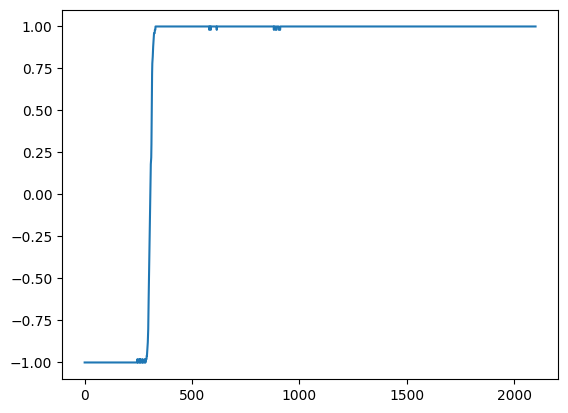

In [97]:
plt.plot(res[area]['roc_score'])